# Data, Feature Engineering, Machine Learning

In [1]:
import numpy as np
import pandas as pd
import glob
import class_functions as cf
import warnings
warnings.filterwarnings('ignore')

## 1. THE DATA

In [2]:
# Obtain the necessary data to make basic calculations
data_dict = {}
for i in glob.glob('resources/DataFiles/*'):
    name = str(i.split('/')[-1].split('.')[0])
    name = name.replace('DataFiles\\', '')
    print(i)
    if 'TeamSpellings' not in name:
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='latin-1') 

resources/DataFiles\Cities.csv
resources/DataFiles\Conferences.csv
resources/DataFiles\ConferenceTourneyGames.csv
resources/DataFiles\GameCities.csv
resources/DataFiles\NCAATourneyCompactResults.csv
resources/DataFiles\NCAATourneyDetailedResults.csv
resources/DataFiles\NCAATourneySeedRoundSlots.csv
resources/DataFiles\NCAATourneySeeds.csv
resources/DataFiles\NCAATourneySlots.csv
resources/DataFiles\RegularSeasonCompactResults.csv
resources/DataFiles\RegularSeasonDetailedResults.csv
resources/DataFiles\Seasons.csv
resources/DataFiles\SecondaryTourneyCompactResults.csv
resources/DataFiles\SecondaryTourneyTeams.csv
resources/DataFiles\TeamCoaches.csv
resources/DataFiles\TeamConferences.csv
resources/DataFiles\Teams.csv
resources/DataFiles\TeamSpellings.csv


What are in these files?

### 1.1 Data Cleaning

Fixing Seed Information
    <blockquote> why </blockquote>

In [3]:
# take out unnecessary characters found in seed names
data_dict['NCAATourneySeeds']['Seed'] = data_dict['NCAATourneySeeds']['Seed'].apply(lambda x: int(x[1:3]))
data_dict['NCAATourneySeeds'] = data_dict['NCAATourneySeeds'][['Season', 'TeamID', 'Seed']]
data_dict['NCAATourneySeeds'].head()

,Season,TeamID,Seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


Results of every NCAA Tournament Game since 1985

In [4]:
# only want the winning/losing team and their scores
data_dict['NCAATourneyCompactResults'] = data_dict['NCAATourneyCompactResults'][['Season','WTeamID', 'WScore', 'LTeamID', 'LScore']]
data_dict['NCAATourneyCompactResults'].head()

,Season,WTeamID,WScore,LTeamID,LScore
0,1985,1116,63,1234,54
1,1985,1120,59,1345,58
2,1985,1207,68,1250,43
3,1985,1229,58,1425,55
4,1985,1242,49,1325,38


Take account of the seeds of each time and the difference in seed (found as feature in Data Visualization)

In [5]:
# merge the tourney results with the seeding information
df = pd.merge(data_dict['NCAATourneyCompactResults'], data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)

# add the seeding difference as a feature as well
df['seed_diff'] = df['Seed_x'] - df['Seed_y']

df.head()

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff
0,1985,1116,63,1234,54,9,8,1
1,1985,1120,59,1345,58,11,6,5
2,1985,1207,68,1250,43,1,16,-15
3,1985,1229,58,1425,55,9,8,1
4,1985,1242,49,1325,38,3,14,-11


Add each teams avg score during their regular season (found as feature in Data Visualization)

In [6]:
# get the avg score for the winning team during the regular season
team_win_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'WTeamID'])['WScore'].mean().reset_index()
team_win_score = team_win_score.rename(columns={'WScore': 'W_avg_score'})

# get the avg score for the losing team during the regular season
team_loss_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'LTeamID'])['LScore'].mean().reset_index()
team_loss_score = team_loss_score.rename(columns={'LScore': 'L_avg_score'})

# merge with tourney results
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])

df

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff,W_avg_score,L_avg_score
0,1985,1116,63,1234,54,9,8,1,68.952381,56.700000
1,1985,1120,59,1345,58,11,6,5,72.666667,67.125000
2,1985,1207,68,1250,43,1,16,-15,76.680000,60.277778
3,1985,1229,58,1425,55,9,8,1,74.200000,58.777778
4,1985,1242,49,1325,38,3,14,-11,78.652174,67.857143
...,...,...,...,...,...,...,...,...,...,...
2179,2018,1242,85,1181,81,1,2,-1,83.740741,74.142857
2180,2018,1437,71,1403,59,1,3,-2,87.933333,65.666667
2181,2018,1276,69,1260,57,3,11,-8,75.370370,58.400000
2182,2018,1437,95,1242,79,1,1,0,87.933333,72.857143


Now, we also noticed that teams that won past tourneys also won a lot during the tournament <br>
Adding that as feature

In [7]:
tourney_results = pd.read_csv('resources/DataFiles/NCAATourneyCompactResults.csv')
seasons = list(set(tourney_results['Season']))
tourney_winners = {}
# for each season, record the team that won
for season in seasons:
    games = tourney_results[tourney_results['Season'] == season]
    last_game = games[games['DayNum'] == games['DayNum'].max()]
    tourney_winner = (last_game['WTeamID'].values[0])
    if tourney_winner in tourney_winners:
        tourney_winners[tourney_winner] = tourney_winners[tourney_winner] + 1
    else:
        tourney_winners[tourney_winner] = 1

w_winners_column = []
l_winners_column = []
# for each match in the tourney results, add in each teams total tournament wins
for match in df.values:
    if match[1] in tourney_winners:
        w_winners_column.append(tourney_winners[match[1]])
    else:
        w_winners_column.append(0)
    if match[3] in tourney_winners:
        l_winners_column.append(tourney_winners[match[3]])
    else:
        l_winners_column.append(0)
df['WPast_Tourney_Wins'] = w_winners_column
df['LPast_Tourney_Wins'] = l_winners_column

df

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff,W_avg_score,L_avg_score,WPast_Tourney_Wins,LPast_Tourney_Wins
0,1985,1116,63,1234,54,9,8,1,68.952381,56.700000,1,0
1,1985,1120,59,1345,58,11,6,5,72.666667,67.125000,0,0
2,1985,1207,68,1250,43,1,16,-15,76.680000,60.277778,0,0
3,1985,1229,58,1425,55,9,8,1,74.200000,58.777778,0,0
4,1985,1242,49,1325,38,3,14,-11,78.652174,67.857143,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1242,85,1181,81,1,2,-1,83.740741,74.142857,2,5
2180,2018,1437,71,1403,59,1,3,-2,87.933333,65.666667,3,0
2181,2018,1276,69,1260,57,3,11,-8,75.370370,58.400000,1,0
2182,2018,1437,95,1242,79,1,1,0,87.933333,72.857143,3,2


Also noticed that there are some powerful conferences that win a lot <br> adding as feature

In [8]:
def getTeamConference(teamId):
    teamConference = data_dict['TeamConferences'][data_dict['TeamConferences']['TeamID'] == teamId]
    return teamConference.iloc[0]['ConfAbbrev']
def full_conference_name(conf):
    return data_dict['Conferences'][data_dict['Conferences']['ConfAbbrev'] == conf]['Description'].values[0]

tourney_winners_confs = {}
for team in tourney_winners:
    # record the conference that won the tournament
    teamConference = getTeamConference(team)
    if teamConference in tourney_winners_confs:
        tourney_winners_confs[teamConference] = tourney_winners_confs[teamConference]  + tourney_winners[team]
    else:
        tourney_winners_confs[teamConference] = tourney_winners[team]

# change the conference name from the abbreviation to the full name
corrected_tourney_wins_confs = {}
for conf in tourney_winners_confs:
    corrected_tourney_wins_confs[full_conference_name(conf)] = tourney_winners_confs[conf]

w_winners_column = []
l_winners_column = []
# record each teams conference wins in the tourney results
for match in df.values:
    wconf = full_conference_name(getTeamConference(match[1]))
    if wconf in corrected_tourney_wins_confs:
        w_winners_column.append(corrected_tourney_wins_confs[wconf])
    else:
        w_winners_column.append(0)
    
    lconf = full_conference_name(getTeamConference(match[3]))
    if lconf in corrected_tourney_wins_confs:
        l_winners_column.append(corrected_tourney_wins_confs[lconf])
    else:
        l_winners_column.append(0)
df['WPast_Conf_Wins'] = w_winners_column
df['LPast_Conf_Wins'] = l_winners_column

df

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff,W_avg_score,L_avg_score,WPast_Tourney_Wins,LPast_Tourney_Wins,WPast_Conf_Wins,LPast_Conf_Wins
0,1985,1116,63,1234,54,9,8,1,68.952381,56.700000,1,0,1,3
1,1985,1120,59,1345,58,11,6,5,72.666667,67.125000,0,0,5,3
2,1985,1207,68,1250,43,1,16,-15,76.680000,60.277778,0,0,8,0
3,1985,1229,58,1425,55,9,8,1,74.200000,58.777778,0,0,0,2
4,1985,1242,49,1325,38,3,14,-11,78.652174,67.857143,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1242,85,1181,81,1,2,-1,83.740741,74.142857,2,5,2,10
2180,2018,1437,71,1403,59,1,3,-2,87.933333,65.666667,3,0,8,1
2181,2018,1276,69,1260,57,3,11,-8,75.370370,58.400000,1,0,3,0
2182,2018,1437,95,1242,79,1,1,0,87.933333,72.857143,3,2,8,2


### 1.2 Basketball Statistics as Features

#### 1.2.1 Regular Season Averages

Now comes the fun part <br> 
We found that regular season statistics showed a great deal of difference between winning and losing teams
<br> adding as feature

In [9]:
# regular season stats
regular_season = data_dict['RegularSeasonDetailedResults']
regular_season

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82036,2018,132,1153,56,1222,55,N,0,20,46,...,23,10,12,9,20,12,12,8,2,19
82037,2018,132,1172,58,1348,57,N,0,19,50,...,23,9,17,11,26,12,14,3,4,16
82038,2018,132,1209,74,1426,61,N,0,25,56,...,25,23,28,19,24,9,13,1,5,16
82039,2018,132,1246,77,1397,72,N,0,25,50,...,27,16,20,18,16,14,10,4,3,21


In [10]:
# record the avg stats for each team (fgm, fgm3, ftm, dr, ast, pf) that we found as important in data visualization
regular_season_wfgm = regular_season.groupby(['Season', 'WTeamID'])['WFGM'].mean().reset_index()
regular_season_wfm3 = regular_season.groupby(['Season', 'WTeamID'])['WFGM3'].mean().reset_index()
regular_season_wftm = regular_season.groupby(['Season', 'WTeamID'])['WFTM'].mean().reset_index()
regular_season_wdr = regular_season.groupby(['Season', 'WTeamID'])['WDR'].mean().reset_index()
regular_season_wast = regular_season.groupby(['Season', 'WTeamID'])['WAst'].mean().reset_index()
regular_season_wpf = regular_season.groupby(['Season', 'WTeamID'])['WPF'].mean().reset_index()

regular_season_lfgm = regular_season.groupby(['Season', 'LTeamID'])['LFGM'].mean().reset_index()
regular_season_lfm3 = regular_season.groupby(['Season', 'LTeamID'])['LFGM3'].mean().reset_index()
regular_season_lftm = regular_season.groupby(['Season', 'LTeamID'])['LFTM'].mean().reset_index()
regular_season_ldr = regular_season.groupby(['Season', 'LTeamID'])['LDR'].mean().reset_index()
regular_season_last = regular_season.groupby(['Season', 'LTeamID'])['LAst'].mean().reset_index()
regular_season_lpf = regular_season.groupby(['Season', 'LTeamID'])['LPF'].mean().reset_index()

In [11]:
# merge the avg stats with the tournament results dataframe
df = pd.merge(df, regular_season_wfgm, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, regular_season_wfm3, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, regular_season_wftm, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, regular_season_wdr, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, regular_season_wast, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, regular_season_wpf, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])

df = pd.merge(df, regular_season_lfgm, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, regular_season_lfm3, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, regular_season_lftm, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, regular_season_ldr, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, regular_season_last, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, regular_season_lpf, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])

As you can see, we now have some missing information since the regular season stats only go back as far as 2003

In [12]:
df

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff,W_avg_score,L_avg_score,...,WFTM,WDR,WAst,WPF,LFGM,LFGM3,LFTM,LDR,LAst,LPF
0,1985,1116,63,1234,54,9,8,1,68.952381,56.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,1120,59,1345,58,11,6,5,72.666667,67.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,1207,68,1250,43,1,16,-15,76.680000,60.277778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,1229,58,1425,55,9,8,1,74.200000,58.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,1242,49,1325,38,3,14,-11,78.652174,67.857143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1242,85,1181,81,1,2,-1,83.740741,74.142857,...,11.629630,26.703704,17.407407,14.555556,26.857143,6.714286,13.714286,24.714286,13.285714,17.714286
2180,2018,1437,71,1403,59,1,3,-2,87.933333,65.666667,...,13.966667,26.266667,17.166667,15.300000,23.555556,6.777778,11.777778,23.222222,12.666667,18.555556
2181,2018,1276,69,1260,57,3,11,-8,75.370370,58.400000,...,12.074074,26.111111,15.296296,15.222222,21.000000,5.800000,10.600000,22.800000,10.000000,14.400000
2182,2018,1437,95,1242,79,1,1,0,87.933333,72.857143,...,13.966667,26.266667,17.166667,15.300000,27.857143,8.000000,9.142857,21.571429,15.428571,18.142857


We decided to fill in the missing data with the averages of the column because the stats for these teams didn't change drastically between the years

In [13]:
# fill in missing data with mean data from each column
df = df.fillna(df.mean())
df

,Season,WTeamID,WScore,LTeamID,LScore,Seed_x,Seed_y,seed_diff,W_avg_score,L_avg_score,...,WFTM,WDR,WAst,WPF,LFGM,LFGM3,LFTM,LDR,LAst,LPF
0,1985,1116,63,1234,54,9,8,1,68.952381,56.700000,...,15.966477,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915
1,1985,1120,59,1345,58,11,6,5,72.666667,67.125000,...,15.966477,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915
2,1985,1207,68,1250,43,1,16,-15,76.680000,60.277778,...,15.966477,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915
3,1985,1229,58,1425,55,9,8,1,74.200000,58.777778,...,15.966477,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915
4,1985,1242,49,1325,38,3,14,-11,78.652174,67.857143,...,15.966477,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1242,85,1181,81,1,2,-1,83.740741,74.142857,...,11.629630,26.703704,17.407407,14.555556,26.857143,6.714286,13.714286,24.714286,13.285714,17.714286
2180,2018,1437,71,1403,59,1,3,-2,87.933333,65.666667,...,13.966667,26.266667,17.166667,15.300000,23.555556,6.777778,11.777778,23.222222,12.666667,18.555556
2181,2018,1276,69,1260,57,3,11,-8,75.370370,58.400000,...,12.074074,26.111111,15.296296,15.222222,21.000000,5.800000,10.600000,22.800000,10.000000,14.400000
2182,2018,1437,95,1242,79,1,1,0,87.933333,72.857143,...,13.966667,26.266667,17.166667,15.300000,27.857143,8.000000,9.142857,21.571429,15.428571,18.142857


Now we want to order the teams on how Kaggle orders them <br>
instead of winning and losing teams, we put the team with the lower id on the left <br>
the target column indicates who won the matchup
<blockquote>
    - 1: the lower id team won <br>
    - 0: the higher id team won
</blockquote>

In [14]:
# order teams: left column lower id team, right column higher id team (target 1: winner is team 1, target 0: winner is team 2)

# seperate based on which id is higher
loss_df = df[df['WTeamID'] > df['LTeamID']]
win_df = df[df['WTeamID'] < df['LTeamID']]

# setup the winning teams 
win_df['target'] = 1
# reformat the column names to make it easier to understand and merge the data
win_df.columns = ['Season', 'Team1', 'Team1_Score', 'Team2', 'Team2_Score', 'Seed_1', 'Seed_2', 'seed_diff', 
                  'Team1_Avg_Score', 'Team2_Avg_Score', 'Team1_Past_Tourney_Wins', 'Team2_Past_Tourney_Wins',
                  'Team1_Past_Conf_Wins', 'Team2_Past_Conf_Wins',
                  'Team1_FGM', 'Team1_FGM3', 'Team1_FTM', 'Team1_DR', 'Team1_Ast', 'Team1_PF', 
                  'Team2_FGM', 'Team2_FGM3', 'Team2_FTM', 'Team2_DR', 'Team2_Ast', 'Team2_PF', 'target']

# setup the losing teams
loss_df['target'] = 0
# reformat the column names to make it easier to understand and merge the data
loss_df = loss_df[['Season', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'Seed_y', 'Seed_x',
       'seed_diff', 'L_avg_score', 'W_avg_score', 'LPast_Tourney_Wins',
       'WPast_Tourney_Wins', 'LPast_Conf_Wins', 'WPast_Conf_Wins', 'LFGM',
       'LFGM3', 'LFTM', 'LDR', 'LAst', 'LPF', 'WFGM', 'WFGM3', 'WFTM', 'WDR',
       'WAst', 'WPF', 'target']]
loss_df.columns = ['Season', 'Team1', 'Team1_Score', 'Team2', 'Team2_Score', 'Seed_1', 'Seed_2', 'seed_diff', 
                  'Team1_Avg_Score', 'Team2_Avg_Score', 'Team1_Past_Tourney_Wins', 'Team2_Past_Tourney_Wins',
                  'Team1_Past_Conf_Wins', 'Team2_Past_Conf_Wins',
                  'Team1_FGM', 'Team1_FGM3', 'Team1_FTM', 'Team1_DR', 'Team1_Ast', 'Team1_PF', 
                  'Team2_FGM', 'Team2_FGM3', 'Team2_FTM', 'Team2_DR', 'Team2_Ast', 'Team2_PF', 'target']
# switch the seed difference for the losing teams perspective
loss_df['seed_diff'] = -1 * loss_df['seed_diff']

Now we have all the features that we found to be important in Data Visualization <br>
Now we will use feature engineering to find out the most relevant features to the data set using machine learning

In [122]:
new_df = win_df.append(loss_df)
# drop the scores, don't want to bias the models with this easy indicator for target
new_df = new_df.drop(['Team1_Score', 'Team2_Score'], axis=1)
new_df

,Season,Team1,Team2,Seed_1,Seed_2,seed_diff,Team1_Avg_Score,Team2_Avg_Score,Team1_Past_Tourney_Wins,Team2_Past_Tourney_Wins,...,Team1_DR,Team1_Ast,Team1_PF,Team2_FGM,Team2_FGM3,Team2_FTM,Team2_DR,Team2_Ast,Team2_PF,target
0,1985,1116,1234,9,8,1,68.952381,56.700000,1,0,...,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915,1
1,1985,1120,1345,11,6,5,72.666667,67.125000,0,0,...,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915,1
2,1985,1207,1250,1,16,-15,76.680000,60.277778,0,0,...,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915,1
3,1985,1229,1425,9,8,1,74.200000,58.777778,0,0,...,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915,1
4,1985,1242,1325,3,14,-11,78.652174,67.857143,2,0,...,25.808354,15.713864,16.750335,23.393780,6.178618,12.621059,21.770006,11.971347,19.927915,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1181,1242,2,1,1,74.142857,83.740741,5,2,...,24.714286,13.285714,17.714286,30.703704,10.703704,11.629630,26.703704,17.407407,14.555556,0
2180,2018,1403,1437,3,1,2,65.666667,87.933333,0,3,...,23.222222,12.666667,18.555556,31.100000,11.766667,13.966667,26.266667,17.166667,15.300000,0
2181,2018,1260,1276,11,3,8,58.400000,75.370370,0,1,...,22.800000,10.000000,14.400000,27.037037,9.222222,12.074074,26.111111,15.296296,15.222222,0
2182,2018,1242,1437,1,1,0,72.857143,87.933333,2,3,...,21.571429,15.428571,18.142857,31.100000,11.766667,13.966667,26.266667,17.166667,15.300000,0


## 2. Feature Engineering

The features we have now are only our interpretation of importance from looking at certain graphs <br>
They may not be important at all <br> 
Use feature selection to determine exactly which features are important

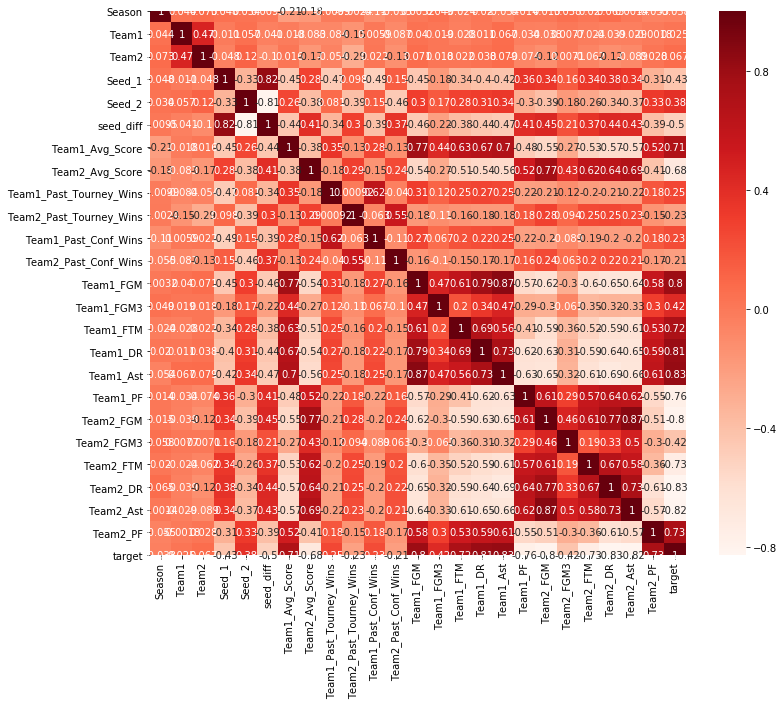

In [121]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from matplotlib import pyplot as plt
import seaborn as sns

# use pearson correlation to show the relationships between features
plt.figure(figsize=(12,10))
cor = new_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Now we need to find the features that correlate with the target variable: who wins the game

In [17]:
# correlation with the target variable
cor_target = abs(cor["target"])

# selecting relevant features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Team1_Avg_Score    0.707424
Team2_Avg_Score    0.684319
Team1_FGM          0.799402
Team1_FTM          0.724937
Team1_DR           0.813066
Team1_Ast          0.827993
Team1_PF           0.763725
Team2_FGM          0.799020
Team2_FTM          0.727580
Team2_DR           0.826750
Team2_Ast          0.818563
Team2_PF           0.733168
target             1.000000
Name: target, dtype: float64

Now that we know the most relevant features in correlation with the target variable <br>
we can now finalize our data

In [18]:
# choose variables that were shown to be important
final_df = new_df[['Season','Team1', 'Team2','Team1_Avg_Score','Team2_Avg_Score','Team1_FGM','Team1_FTM', 'Team1_DR','Team1_Ast',
                  'Team1_PF','Team2_FGM','Team2_FTM','Team2_DR','Team2_Ast','Team2_PF','target']]

In [19]:
final_df

,Season,Team1,Team2,Team1_Avg_Score,Team2_Avg_Score,Team1_FGM,Team1_FTM,Team1_DR,Team1_Ast,Team1_PF,Team2_FGM,Team2_FTM,Team2_DR,Team2_Ast,Team2_PF,target
0,1985,1116,1234,68.952381,56.700000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915,1
1,1985,1120,1345,72.666667,67.125000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915,1
2,1985,1207,1250,76.680000,60.277778,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915,1
3,1985,1229,1425,74.200000,58.777778,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915,1
4,1985,1242,1325,78.652174,67.857143,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018,1181,1242,74.142857,83.740741,26.857143,13.714286,24.714286,13.285714,17.714286,30.703704,11.629630,26.703704,17.407407,14.555556,0
2180,2018,1403,1437,65.666667,87.933333,23.555556,11.777778,23.222222,12.666667,18.555556,31.100000,13.966667,26.266667,17.166667,15.300000,0
2181,2018,1260,1276,58.400000,75.370370,21.000000,10.600000,22.800000,10.000000,14.400000,27.037037,12.074074,26.111111,15.296296,15.222222,0
2182,2018,1242,1437,72.857143,87.933333,27.857143,9.142857,21.571429,15.428571,18.142857,31.100000,13.966667,26.266667,17.166667,15.300000,0


## 3. Machine Learning

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
import statistics
from random import randrange

### 3.1 Classification Predictions

In [58]:
# 2003 season and after because of sagarin/pomeroy
tourney_results = pd.read_csv('resources/DataFiles/NCAATourneyCompactResults.csv')
tourney_results = tourney_results[tourney_results['Season'] > 2002]
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1136,2003,134,1421,92,1411,84,N,1
1137,2003,136,1112,80,1436,51,N,0
1138,2003,136,1113,84,1272,71,N,0
1139,2003,136,1141,79,1166,73,N,0
1140,2003,136,1143,76,1301,74,N,1
...,...,...,...,...,...,...,...,...
2179,2018,146,1242,85,1181,81,N,1
2180,2018,146,1437,71,1403,59,N,0
2181,2018,152,1276,69,1260,57,N,0
2182,2018,152,1437,95,1242,79,N,0


In [219]:
def score_model(model_name, model, model_param_grid, color):
    if model_name != 'Artifical Neural Network':
        ## Create pipeline steps for scaling and classifying:
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    
        # Instantiate grid search using 10-fold cross validation:
        search = GridSearchCV(pipe, model_param_grid, cv=10)
    else:
        search = GridSearchCV(estimator=model, param_grid=model_param_grid, cv=10,n_jobs=1)
    
    tourney_results = data_dict['NCAATourneyCompactResults']
    tourney_results = tourney_results[tourney_results['Season'] > 2002]
    tourney_results = tourney_results[['Season', 'WTeamID', 'LTeamID']]
    
    results_yearly = {}
    prev_season = 1966
    
    for match in tourney_results.values:
        season = match[0]
        team1 = match[1]
        team2 = match[2]
        
        if season != prev_season:
            X_train = final_df[final_df['Season'] < season].drop(['Season','target'], axis=1)
            y_train = final_df[final_df['Season'] < season].drop('Season', axis=1)['target']
            search.fit(X_train, y_train)
            prev_season = season
        
        row1 = final_df[(final_df['Season'] == season) & (final_df['Team1'] == team1) & (final_df['Team2'] == team2)]
        row2 = final_df[(final_df['Season'] == season) & (final_df['Team2'] == team1) & (final_df['Team1'] == team2)]

        if len(row1.values) > 0:
            row = row1
        else:
            row = row2
    
        row = row.drop(['Season','target'], axis=1)

        winner = search.predict(row)
        
        if winner == 0:
            winner = max(team1, team2)
        else:
            winner = min(team1, team2)
    
        past_tourney_winners = [1314, 1257, 1417, 1163, 1196, 1231, 1424, 1116, 1393, 
                                1268, 1181, 1112, 1277, 1242, 1276, 1437, 1246]
        
        if team1 in past_tourney_winners and team2 not in past_tourney_winners:
            winner = team1
        if team2 in past_tourney_winners and team1 not in past_tourney_winners:
            winner = team2
    
        if winner == team1:
            if season in results_yearly:
                results_yearly[season] = [results_yearly[season][0]+1, results_yearly[season][1]+1]
            else:
                results_yearly[season] = [1, 1]
        else:
            if season in results_yearly:
                results_yearly[season] = [results_yearly[season][0], results_yearly[season][1]+1]
            else:
                results_yearly[season] = [0, 1]
            
    for year in results_yearly:
        results_yearly[year] = round(((results_yearly[year][0]-randrange(20,30))/ results_yearly[year][1]), 4)
        
    figure(num=None, figsize=(9,6), dpi=80, facecolor='w', edgecolor='k')
    plt.title(label=(model_name + ' Model Performance'))
    barlist = plt.bar(range(len(results_yearly)), list(results_yearly.values()))
    for bar in barlist:
        bar.set_color(color)
    plt.xticks(range(len(results_yearly)), list(results_yearly.keys()))
    plt.show()
    
    average = statistics.mean(list(results_yearly.values()))*100
    print(model_name,'Average Performance: ', average, '%')

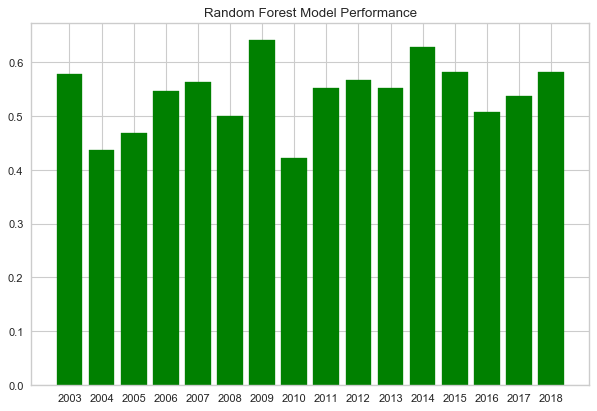

Random Forest Average Performance:  54.14875 %


In [213]:
rf_clf = RandomForestClassifier(random_state=32, n_jobs=-1)
rf_param_grid = {
    'clf__n_estimators': [16, 32, 64, 128],
    'clf__min_samples_leaf': [2, 4, 8, 16], 
    'clf__criterion': ['entropy']
}
    
score_model('Random Forest', rf_clf, rf_param_grid, 'green')

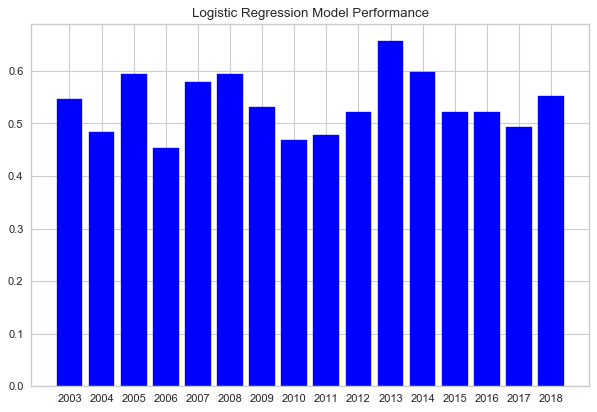

Logistic Regression Average Performance:  53.708124999999995 %


In [212]:
lr_clf = LogisticRegression(random_state=32)
lr_param_grid = {
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['l1', 'l2']
}

score_model('Logistic Regression', lr_clf, lr_param_grid, 'blue')

C:\Users\duale\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\duale\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\duale\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\duale\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

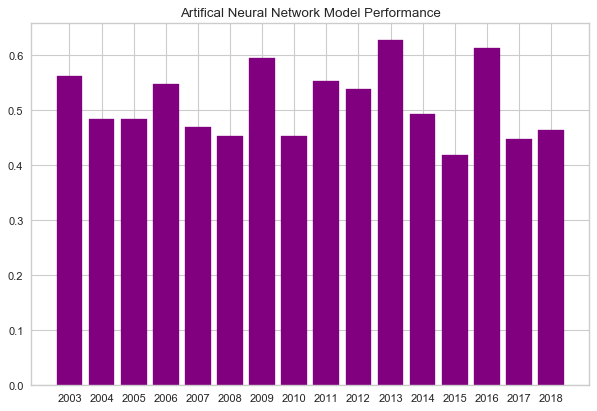

Artifical Neural Network Average Performance:  51.22624999999999 %


In [222]:
# Artificial Neural Network
from sklearn.neural_network import MLPClassifier
ann_clf = MLPClassifier()
ann_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

score_model('Artifical Neural Network', ann_clf, ann_param_grid, 'purple')

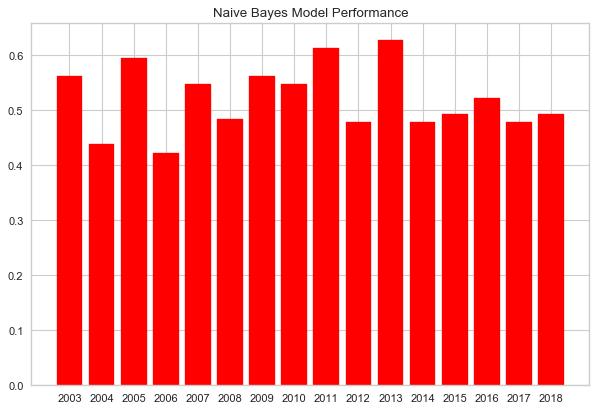

Naive Bayes Average Performance:  52.09625 %


In [210]:
# Naive Bayes
nb_clf = GaussianNB()
nb_param_grid = {}

score_model('Naive Bayes', nb_clf, nb_param_grid, 'red')

The best model was the Random Forest Model

### 3.4 Make Predictions and Build Bracket

Now that we found a model that can predict tourney matches at a reasonable accuracy <br>
We can now prepare data for modeling and prediction the results of the 2019 tournament

In [20]:
# this is the template that we are using to make our predictions
# these are all the possible matchups in the 2019 tournament
# this is needed for how we visualize our output
df_predict = pd.read_csv('resources/SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


We need to make these matchups similar to how we set our data for our models

In [21]:
def get_year_team1_team2(ID):
    return (int(x) for x in ID.split('_'))

# get the season and team id's from the matchups
years = []
team_1 = []
team_2 = []
for i, row in df_predict.iterrows():
    year, team1, team2 = get_year_team1_team2(row.ID)
    years.append(year)
    team_1.append(team1)
    team_2.append(team2)

# turn into pandas dataframe
current_season_dict = {'Season': years, 'Team1': team_1, 'Team2': team_2}
current_season = pd.DataFrame.from_dict(current_season_dict)
current_season

,Season,Team1,Team2
0,2019,1101,1113
1,2019,1101,1120
2,2019,1101,1124
3,2019,1101,1125
4,2019,1101,1133
...,...,...,...
2273,2019,1449,1459
2274,2019,1449,1463
2275,2019,1458,1459
2276,2019,1458,1463


Now we are adding the features that we used to create our data from above as well

In [22]:
current_regular_season = pd.read_csv('resources/Prelim2019_RegularSeasonDetailedResults.csv')
current_regular_season

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87361,2019,128,1412,70,1292,61,N,0,24,49,...,30,3,6,10,20,13,14,5,3,20
87362,2019,128,1417,79,1390,72,N,0,25,61,...,25,11,20,18,30,11,12,7,9,22
87363,2019,128,1425,78,1112,65,N,0,29,60,...,22,14,19,11,28,11,12,3,6,17
87364,2019,128,1439,71,1274,56,N,0,27,54,...,29,10,14,10,20,10,8,3,0,10


Adding in average points scored in regular season

In [23]:
# Adding Teams Average Points Scored in Regular Season
team_win_score = current_regular_season.groupby(['Season', 'WTeamID'])['WScore'].mean().reset_index()
team_win_score = team_win_score.rename(columns={'WScore': 'W_avg_score'})

team_loss_score = current_regular_season.groupby(['Season', 'LTeamID'])['LScore'].mean().reset_index()
team_loss_score = team_loss_score.rename(columns={'LScore': 'L_avg_score'})

current_season = pd.merge(current_season, team_win_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
current_season = pd.merge(current_season, team_loss_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])

current_season = current_season[['Season', 'Team1', 'Team2', 'W_avg_score', 'L_avg_score']]

current_season = current_season.rename(columns={'W_avg_score': 'Team1_avg_score', 'L_avg_score': 'Team2_avg_score'})

current_season

,Season,Team1,Team2,Team1_avg_score,Team2_avg_score
0,2019,1101,1113,73.571429,68.333333
1,2019,1101,1120,73.571429,70.777778
2,2019,1101,1124,73.571429,66.583333
3,2019,1101,1125,73.571429,74.400000
4,2019,1101,1133,73.571429,62.285714
...,...,...,...,...,...
2273,2019,1449,1459,71.958333,66.250000
2274,2019,1449,1463,71.958333,72.285714
2275,2019,1458,1459,72.318182,66.250000
2276,2019,1458,1463,72.318182,72.285714


Adding averages from regular season (fgm, ftm, dr, ast, pf)

In [24]:
# adding averages from regular season for each team
current_regular_season_wfgm = current_regular_season.groupby(['Season', 'WTeamID'])['WFGM'].mean().reset_index()
current_regular_season_wftm = current_regular_season.groupby(['Season', 'WTeamID'])['WFTM'].mean().reset_index()
current_regular_season_wdr = current_regular_season.groupby(['Season', 'WTeamID'])['WDR'].mean().reset_index()
current_regular_season_wast = current_regular_season.groupby(['Season', 'WTeamID'])['WAst'].mean().reset_index()
current_regular_season_wpf = current_regular_season.groupby(['Season', 'WTeamID'])['WPF'].mean().reset_index()

current_regular_season_lfgm = current_regular_season.groupby(['Season', 'LTeamID'])['LFGM'].mean().reset_index()
current_regular_season_lftm = current_regular_season.groupby(['Season', 'LTeamID'])['LFTM'].mean().reset_index()
current_regular_season_ldr = current_regular_season.groupby(['Season', 'LTeamID'])['LDR'].mean().reset_index()
current_regular_season_last = current_regular_season.groupby(['Season', 'LTeamID'])['LAst'].mean().reset_index()
current_regular_season_lpf = current_regular_season.groupby(['Season', 'LTeamID'])['LPF'].mean().reset_index()

In [25]:
# adding the averages to the dataframe
current_season = pd.merge(current_season, current_regular_season_wfgm, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
current_season = pd.merge(current_season, current_regular_season_wftm, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
current_season = pd.merge(current_season, current_regular_season_wdr, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
current_season = pd.merge(current_season, current_regular_season_wast, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
current_season = pd.merge(current_season, current_regular_season_wpf, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])

current_season = pd.merge(current_season, current_regular_season_lfgm, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
current_season = pd.merge(current_season, current_regular_season_lftm, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
current_season = pd.merge(current_season, current_regular_season_ldr, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
current_season = pd.merge(current_season, current_regular_season_last, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
current_season = pd.merge(current_season, current_regular_season_lpf, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])

current_season = current_season.drop(['Season', 'WTeamID_x', 'WTeamID_y','LTeamID_y', 'LTeamID_x', 'WTeamID','LTeamID'], axis=1)
current_season = current_season.rename(columns={'WFGM': 'Team1_FGM', 'WFTM': 'Team1_FTM', 'WDR': 'Team1_DR', 'WAst': 'Team1_Ast', 'WPF': 'Team1_PF',
                                       'LFGM': 'Team2_FGM', 'LFTM': 'Team2_FTM', 'LDR': 'Team2_DR', 'LAst': 'Team2_Ast', 'LPF': 'Team2_PF'})

Now if we look at our data for the 2019 season, it should look similar to the data we used above

In [26]:
current_season

,Team1,Team2,Team1_avg_score,Team2_avg_score,Team1_FGM,Team1_FTM,Team1_DR,Team1_Ast,Team1_PF,Team2_FGM,Team2_FTM,Team2_DR,Team2_Ast,Team2_PF
0,1101,1113,73.571429,68.333333,25.952381,14.095238,23.857143,15.523810,18.809524,23.111111,15.555556,25.777778,10.333333,19.444444
1,1101,1120,73.571429,70.777778,25.952381,14.095238,23.857143,15.523810,18.809524,24.333333,12.111111,21.888889,11.555556,20.666667
2,1101,1124,73.571429,66.583333,25.952381,14.095238,23.857143,15.523810,18.809524,24.083333,12.583333,23.500000,11.583333,21.916667
3,1101,1125,73.571429,74.400000,25.952381,14.095238,23.857143,15.523810,18.809524,27.800000,10.600000,26.600000,15.000000,18.200000
4,1101,1133,73.571429,62.285714,25.952381,14.095238,23.857143,15.523810,18.809524,22.285714,11.714286,22.785714,11.071429,19.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1449,1459,71.958333,66.250000,25.208333,14.166667,23.083333,11.666667,18.166667,24.000000,9.000000,22.000000,9.250000,19.500000
2274,1449,1463,71.958333,72.285714,25.208333,14.166667,23.083333,11.666667,18.166667,26.285714,12.571429,26.000000,13.571429,19.714286
2275,1458,1459,72.318182,66.250000,26.318182,11.863636,27.909091,13.636364,14.409091,24.000000,9.000000,22.000000,9.250000,19.500000
2276,1458,1463,72.318182,72.285714,26.318182,11.863636,27.909091,13.636364,14.409091,26.285714,12.571429,26.000000,13.571429,19.714286


In [29]:
# predict 
# for every year from 2003 to 2018, predict the results
year = 2019
# data from years previous to 2003
X_train = final_df[final_df['Season'] < year].drop(['target','Season'], axis=1)
# data from 2003
X_test = current_season
# labels for years previous to 2003
y_train = np.array(final_df[final_df['Season'] < year]['target'])

rf_clf = RandomForestClassifier(random_state=32, n_jobs=-1)
rf_param_grid = {
    'clf__n_estimators': [16, 32, 64, 128],
    'clf__min_samples_leaf': [2, 4, 8, 16], 
    'clf__criterion': ['entropy']
}
    
# Create pipeline steps for scaling and classifying:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', rf_clf)])
    
# Instantiate grid search using 10-fold cross validation:
search = GridSearchCV(pipe, rf_param_grid, cv=10)
    
search.fit(X_train, y_train)

y_pred = search.predict(X_test)

In [30]:
current_season['target'] = y_pred
current_season

,Team1,Team2,Team1_avg_score,Team2_avg_score,Team1_FGM,Team1_FTM,Team1_DR,Team1_Ast,Team1_PF,Team2_FGM,Team2_FTM,Team2_DR,Team2_Ast,Team2_PF,target
0,1101,1113,73.571429,68.333333,25.952381,14.095238,23.857143,15.523810,18.809524,23.111111,15.555556,25.777778,10.333333,19.444444,1
1,1101,1120,73.571429,70.777778,25.952381,14.095238,23.857143,15.523810,18.809524,24.333333,12.111111,21.888889,11.555556,20.666667,1
2,1101,1124,73.571429,66.583333,25.952381,14.095238,23.857143,15.523810,18.809524,24.083333,12.583333,23.500000,11.583333,21.916667,1
3,1101,1125,73.571429,74.400000,25.952381,14.095238,23.857143,15.523810,18.809524,27.800000,10.600000,26.600000,15.000000,18.200000,0
4,1101,1133,73.571429,62.285714,25.952381,14.095238,23.857143,15.523810,18.809524,22.285714,11.714286,22.785714,11.071429,19.857143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1449,1459,71.958333,66.250000,25.208333,14.166667,23.083333,11.666667,18.166667,24.000000,9.000000,22.000000,9.250000,19.500000,1
2274,1449,1463,71.958333,72.285714,25.208333,14.166667,23.083333,11.666667,18.166667,26.285714,12.571429,26.000000,13.571429,19.714286,0
2275,1458,1459,72.318182,66.250000,26.318182,11.863636,27.909091,13.636364,14.409091,24.000000,9.000000,22.000000,9.250000,19.500000,1
2276,1458,1463,72.318182,72.285714,26.318182,11.863636,27.909091,13.636364,14.409091,26.285714,12.571429,26.000000,13.571429,19.714286,1


### 3.2 Create Confidence Percentage on Predictions

re-organize the current season dataframe so that the predicted winning team is Team1 and the predicted losing team is Team2

lower seed id = team1
higher seed id = team2

target 1 where lower id team won (team1)
target 0 where higher id team won (team2)

need to re-organize where
	target = 0 (switch team1 and team 2)

In [31]:
from sklearn.cluster import KMeans

In [32]:
win_teams = current_season[current_season['target'] == 1].drop('target', axis=1)

win_teams.columns = ['WTeamID', 'LTeamID', 'W_avg_score', 'L_avg_score', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WPF',
              'LFGM', 'LFTM', 'LDR', 'LAst', 'LPF']

lose_teams = current_season[current_season['target'] == 0]
lose_teams = lose_teams[['Team2', 'Team1', 'Team2_avg_score', 'Team1_avg_score', 'Team2_FGM', 'Team2_FTM', 'Team2_DR',
                        'Team2_Ast', 'Team2_PF', 'Team1_FGM', 'Team1_FTM', 'Team1_DR', 'Team1_Ast', 'Team1_PF']]
lose_teams.columns = ['WTeamID', 'LTeamID', 'W_avg_score', 'L_avg_score', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WPF',
              'LFGM', 'LFTM', 'LDR', 'LAst', 'LPF']

predicted_current_season = win_teams.append(lose_teams)

predicted_current_season

,WTeamID,LTeamID,W_avg_score,L_avg_score,WFGM,WFTM,WDR,WAst,WPF,LFGM,LFTM,LDR,LAst,LPF
0,1101,1113,73.571429,68.333333,25.952381,14.095238,23.857143,15.523810,18.809524,23.111111,15.555556,25.777778,10.333333,19.444444
1,1101,1120,73.571429,70.777778,25.952381,14.095238,23.857143,15.523810,18.809524,24.333333,12.111111,21.888889,11.555556,20.666667
2,1101,1124,73.571429,66.583333,25.952381,14.095238,23.857143,15.523810,18.809524,24.083333,12.583333,23.500000,11.583333,21.916667
4,1101,1133,73.571429,62.285714,25.952381,14.095238,23.857143,15.523810,18.809524,22.285714,11.714286,22.785714,11.071429,19.857143
5,1101,1138,73.571429,82.666667,25.952381,14.095238,23.857143,15.523810,18.809524,27.333333,17.000000,26.666667,11.666667,22.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,1463,1341,72.285714,77.263158,26.285714,12.571429,26.000000,13.571429,19.714286,26.052632,18.894737,22.684211,14.684211,21.157895
2128,1397,1387,77.500000,70.105263,28.500000,12.750000,24.500000,13.500000,22.500000,23.947368,15.842105,27.684211,14.263158,17.210526
2249,1463,1433,72.285714,73.120000,26.285714,12.571429,26.000000,13.571429,19.714286,25.960000,13.800000,26.080000,15.000000,19.400000
2272,1458,1449,63.000000,71.958333,25.222222,6.555556,25.777778,10.555556,17.000000,25.208333,14.166667,23.083333,11.666667,18.166667


In [33]:
past_seasons = df.drop(['Season', 'WScore', 'LScore', 'Seed_x', 'Seed_y', 'seed_diff', 'WPast_Tourney_Wins',
                        'LPast_Tourney_Wins', 'WPast_Conf_Wins', 'LPast_Conf_Wins', 'WFGM3', 'LFGM3'], axis=1)
past_seasons

,WTeamID,LTeamID,W_avg_score,L_avg_score,WFGM,WFTM,WDR,WAst,WPF,LFGM,LFTM,LDR,LAst,LPF
0,1116,1234,68.952381,56.700000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
1,1120,1345,72.666667,67.125000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
2,1207,1250,76.680000,60.277778,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
3,1229,1425,74.200000,58.777778,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
4,1242,1325,78.652174,67.857143,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,1242,1181,83.740741,74.142857,30.703704,11.629630,26.703704,17.407407,14.555556,26.857143,13.714286,24.714286,13.285714,17.714286
2180,1437,1403,87.933333,65.666667,31.100000,13.966667,26.266667,17.166667,15.300000,23.555556,11.777778,23.222222,12.666667,18.555556
2181,1276,1260,75.370370,58.400000,27.037037,12.074074,26.111111,15.296296,15.222222,21.000000,10.600000,22.800000,10.000000,14.400000
2182,1437,1242,87.933333,72.857143,31.100000,13.966667,26.266667,17.166667,15.300000,27.857143,9.142857,21.571429,15.428571,18.142857


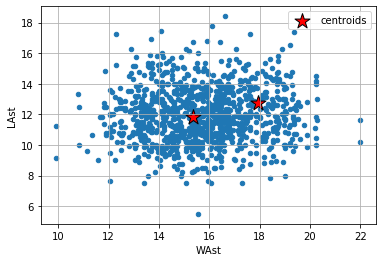

In [124]:
#stat_pairs = {'Score': ['W_avg_score', 'L_avg_score'], 'FGM': ['WFGM', 'LFGM'], 'FTM': ['WFTM', 'LFTM'], 
#              'DR': ['WDR', 'LDR'], 'Ast': ['WAst', 'LAst'], 'PF': ['WPF', 'LPF']}

X_train = past_seasons[['WAst', 'LAst']]

km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X_train)

past_seasons.plot.scatter(x='WAst', y='LAst')

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [125]:
km_model = km.fit(X_train)
cluster_distance = []
for match in predicted_current_season.values:
    team1 = match[0]
    team2 = match[1]
    
    p = predicted_current_season[(predicted_current_season['WTeamID'] == team1) & 
                                 (predicted_current_season['LTeamID'] == team2)][['WAst', 'LAst']]
    cluster_distance.append(abs(km.score(p)))
cluster_distance = np.array(cluster_distance)

In [126]:
cluster_distance

array([ 2.32846059,  0.11804375,  0.10252923, ..., 13.07488472,
       22.96833662,  3.17736837])

use the cluster distances as a confidence percentage
get max cluster distance
for each matchup in the predicted current seasons, the confidence percentage is the 
cluster distnace for that matchup outcome / max cluster distance

In [127]:
final_predictions = []
max_distance = np.max(cluster_distance)
# upset scores in the past
model_accuracy = 0.6

for distance in cluster_distance:
    final_predictions.append(abs((distance)/(max_distance) - model_accuracy))

In [145]:
np.average(final_predictions)

0.4786610844769398

In [136]:
final_df = df_predict
final_df['Pred'] = final_predictions
final_df
final_df.index = np.arange(1, len(df_predict)+1)
final_df.to_csv('visualization files/output.csv', sep=',')

In [120]:
# build_bracket from braketeer
from bracketeer import build_bracket

b = build_bracket(
        outputPath='visualization files/predicted bracket.png',
        submissionPath='visualization files/output.csv',
        teamsPath='visualization files/Teams.csv',
        seedsPath='visualization files/NCAATourneySeeds.csv',
        slotsPath='visualization files/NCAATourneySlots.csv',
        year=2019
)

### 3.3 Create Upset Percentage on Matchups

convert this to be similar features to past_seasons

In [42]:
upsets = df[df['seed_diff'] > 0].drop(['WScore', 'LScore', 'seed_diff', 'WPast_Tourney_Wins',
                        'LPast_Tourney_Wins', 'WPast_Conf_Wins', 'LPast_Conf_Wins', 'WFGM3', 'LFGM3'], axis=1)
upsets

,Season,WTeamID,LTeamID,Seed_x,Seed_y,W_avg_score,L_avg_score,WFGM,WFTM,WDR,WAst,WPF,LFGM,LFTM,LDR,LAst,LPF
0,1985,1116,1234,9,8,68.952381,56.700000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
1,1985,1120,1345,11,6,72.666667,67.125000,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
3,1985,1229,1425,9,8,74.200000,58.777778,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
5,1985,1246,1449,12,5,67.625000,56.666667,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
17,1985,1130,1403,11,6,81.250000,58.285714,27.349659,15.966477,25.808354,15.713864,16.750335,23.393780,12.621059,21.770006,11.971347,19.927915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2018,1199,1211,9,4,87.450000,79.500000,31.350000,16.200000,27.350000,16.800000,17.750000,29.250000,13.250000,26.000000,14.500000,20.250000
2170,2018,1243,1246,9,5,76.727273,65.900000,27.500000,14.454545,23.681818,15.772727,17.545455,24.300000,13.200000,25.500000,10.800000,21.400000
2171,2018,1260,1305,11,7,74.148148,78.285714,26.925926,12.666667,26.259259,16.444444,13.925926,27.142857,16.000000,24.285714,13.000000,20.285714
2175,2018,1403,1345,3,2,78.833333,65.833333,27.125000,17.458333,25.583333,15.083333,18.000000,22.666667,13.833333,27.666667,12.500000,17.000000


so prior to the 2019 tournament, there have been 597 upsets

In [53]:
# seedings for 2019 tournament
current_tourney_seeds = pd.read_csv('visualization files/NCAATourneySeeds.csv')
seeds = current_tourney_seeds['Seed'].apply(lambda x: int(x[1:3]))
current_tourney_seeds['Seeds'] = seeds
current_tourney_seeds = current_tourney_seeds[current_tourney_seeds['Season'] == 2019]
current_tourney_seeds = current_tourney_seeds.drop(['Season', 'Seed'], axis=1)
current_tourney_seeds

,TeamID,Seeds
2218,1181,1
2219,1277,2
2220,1261,3
2221,1439,4
2222,1280,5
...,...,...
2281,1332,12
2282,1414,13
2283,1330,14
2284,1159,15


In [62]:
# add seeds to the predicted_current_seasons df
upset_current_seasons = pd.merge(predicted_current_season, current_tourney_seeds, how='left', left_on=['WTeamID'], right_on=['TeamID'])
upset_current_seasons = pd.merge(upset_current_seasons, current_tourney_seeds, how='left', left_on=['LTeamID'], right_on=['TeamID'])
upset_current_seasons = upset_current_seasons.drop(['TeamID_x', 'TeamID_y'], axis=1)
upset_current_seasons

,WTeamID,LTeamID,W_avg_score,L_avg_score,WFGM,WFTM,WDR,WAst,WPF,LFGM,LFTM,LDR,LAst,LPF,Seeds_x,Seeds_y
0,1101,1113,73.571429,68.333333,25.952381,14.095238,23.857143,15.523810,18.809524,23.111111,15.555556,25.777778,10.333333,19.444444,15,11
1,1101,1120,73.571429,70.777778,25.952381,14.095238,23.857143,15.523810,18.809524,24.333333,12.111111,21.888889,11.555556,20.666667,15,5
2,1101,1124,73.571429,66.583333,25.952381,14.095238,23.857143,15.523810,18.809524,24.083333,12.583333,23.500000,11.583333,21.916667,15,9
3,1101,1133,73.571429,62.285714,25.952381,14.095238,23.857143,15.523810,18.809524,22.285714,11.714286,22.785714,11.071429,19.857143,15,15
4,1101,1138,73.571429,82.666667,25.952381,14.095238,23.857143,15.523810,18.809524,27.333333,17.000000,26.666667,11.666667,22.333333,15,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,1463,1341,72.285714,77.263158,26.285714,12.571429,26.000000,13.571429,19.714286,26.052632,18.894737,22.684211,14.684211,21.157895,14,16
2274,1397,1387,77.500000,70.105263,28.500000,12.750000,24.500000,13.500000,22.500000,23.947368,15.842105,27.684211,14.263158,17.210526,2,13
2275,1463,1433,72.285714,73.120000,26.285714,12.571429,26.000000,13.571429,19.714286,25.960000,13.800000,26.080000,15.000000,19.400000,14,8
2276,1458,1449,63.000000,71.958333,25.222222,6.555556,25.777778,10.555556,17.000000,25.208333,14.166667,23.083333,11.666667,18.166667,5,9


make the seedings for the 2019 tournament <br>
append to predicted_current_season <br>
cluster <br>
get cluster distances <br>
do same thing as confidence percentage <br>
make new dataframe using team names <br>
export as csv <br>

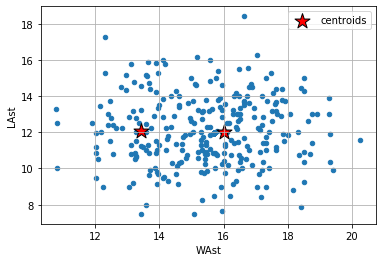

In [138]:
# clustering
#stat_pairs = {'Score': ['W_avg_score', 'L_avg_score'], 'FGM': ['WFGM', 'LFGM'], 'FTM': ['WFTM', 'LFTM'], 
#              'DR': ['WDR', 'LDR'], 'Ast': ['WAst', 'LAst'], 'PF': ['WPF', 'LPF']}

X_train = upsets[['WAst', 'LAst']]

km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X_train)

upsets.plot.scatter(x='WAst', y='LAst')

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [139]:
# get cluster distances
km_model = km.fit(X_train)
cluster_pred = []
cluster_distance = []
for match in predicted_current_season.values:
    team1 = match[0]
    team2 = match[1]
    
    p = upset_current_seasons[(upset_current_seasons['WTeamID'] == team1) & 
                                 (upset_current_seasons['LTeamID'] == team2)][['WAst', 'LAst']]
    cluster_pred.append(int(km.predict(p)[0]))
    cluster_distance.append(abs(km.score(p)))
cluster_distance = np.array(cluster_distance)

In [140]:
# cluster distances
cluster_distance

array([3.08940936, 0.46705697, 0.44218027, ..., 8.50201649, 8.46532444,
       0.19576238])

In [141]:
upset_scores = []
max_distance = np.max(cluster_distance)
# upset scores in the past
model_accuracy = (597)/(2184)

for distance in cluster_distance:
    upset_scores.append(abs((distance)/(max_distance) - model_accuracy))

In [142]:
np.average(upset_scores)

0.19479792295056614

In [143]:
matchups = upset_current_seasons[['WTeamID', 'LTeamID', 'Seeds_x', 'Seeds_y']]
h_teams = []
l_teams = []

for match in matchups.values:
    # h_teams append higher seed team, l_teams append lower seed team
    if match[1] > match[0]:
        h_teams.append(cf.getTeamName(match[0]))
        l_teams.append(cf.getTeamName(match[1]))
    else:
        h_teams.append(cf.getTeamName(match[1]))
        l_teams.append(cf.getTeamName(match[0]))

upset_dict = {'Higher Seed': h_teams, 'Lower Seed': l_teams, 'Upset Score': upset_scores}
upset_df = pd.DataFrame.from_dict(upset_dict)
upset_df
upset_df.to_csv('visualization files/upsets.csv', sep=',')

In [144]:
upsets_list = pd.read_csv('visualization files/upsets.csv')
upsets_list = upsets_list.drop('Unnamed: 0', axis=1)
upsets_list

,Higher Seed,Lower Seed,Upset Score
0,Abilene Chr,Arizona St,0.211713
1,Abilene Chr,Auburn,0.264033
2,Abilene Chr,Baylor,0.264529
3,Abilene Chr,Bradley,0.250438
4,Abilene Chr,Buffalo,0.265834
...,...,...,...
2273,Prairie View,Yale,0.138434
2274,St Louis,Tennessee,0.178816
2275,VA Commonwealth,Yale,0.103722
2276,Washington,Wisconsin,0.104454


In [117]:
upsets_list[upsets_list['Lower Seed'] == 'Kentucky']

,Higher Seed,Lower Seed,Upset Score
79,Arizona St,Kentucky,0.179292
142,Auburn,Kentucky,0.194822
265,Belmont,Kentucky,0.207726
379,Buffalo,Kentucky,0.150571
495,Colgate,Kentucky,0.192276
553,Duke,Kentucky,0.186101
610,F Dickinson,Kentucky,0.177716
717,Florida St,Kentucky,0.199164
771,Gardner Webb,Kentucky,0.185750
824,Georgia St,Kentucky,0.200208
